## Particle within radius or overlap calculations

In [6]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

#misc
import time
np.set_printoptions(suppress=True)

In [7]:
set_number = 5

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'
dir_save = '../../../Research/Images/Images/figureMar24/'


wind_load= 'wind0'+str(set_number)+'Run03_InterpolatedX.hdf'
wind_load_small = 'wind0'+str(set_number)+'Run03_InterpolatedXs.hdf'

windn = pd.read_hdf(dir+wind_load)
windsm = pd.read_hdf(dir+wind_load_small)
# collection_number=1
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run05/Collections/'
# dir_save = '../../data/Sprints/Run05/Collections/Figures/'

# wind_load= 'Run05Coll0'+str(collection_number)+'_InterpolatedX.hdf'
# wind_load_small = 'Run05Coll0'+str(collection_number)+'_InterpolatedXs.hdf'

# windn = pd.read_hdf(dir+wind_load)
# windsm = pd.read_hdf(dir+wind_load_small)

### Calculate Expected encounters

In [8]:
df = pd.DataFrame()
df = windn
dt= df.master_time[1]-df.master_time[0]

In [9]:
sync_time = df.master_time-df.master_time[0]
df.insert(1,'sync_time',sync_time)

In [10]:
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 
source = np.array([[0,0]])
distance_from_source = np.array([cdist(odor_position,source)]).flatten()

### Is Encountered odor particle within the Calculated particle radius?

The loop below computes locations of the eastwest and northsouth particles and compares with a radius (distance) to interpret if the encountered particle were close to calculated particle. The execution for the loop is 23.56 seconds for 59770 rows of data

For stationery wind sensor: The loop below takes in ith eastwest and subtracts the ith U and V elements to get the i-1 state, as the eastwest is summation of all the wind positions. 

[3 + 2 + 1] = [6]

hence ith _state = 6

_state = _state-3

_state = _state-2




In [11]:
#summation till Nth particle
eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]

In [12]:
odor_presence=[]
min_distance = []
max_radius = []

#for(upper, lower, step)
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
        max_radius.append(0)
    else:
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        radius = np.arange(start = i, stop = 0, step = -1)**0.5*0.01
        max_radius.append(i**0.5*0.1)
    #TODO: Model better radius
    #max_radius= np.max(radius)
    distance = cdist(odor_pos,wind_pos).flatten()   # cdist compares distance for all the points in both arrays
    min_distance.append(np.min(distance))
    #distance = distance[distance(distance<max_radius)]     #this step can reduce computation but arises issues 
                                                           #for different length arrays for distance and radius
    
    #TODO: Find a way to reduce distance array size and compare without increasing the overall execution time
    
    ## NOTE : COMPARING EVERY DISTANCE TO THE CORRESPONDING RADIUS TO SEE IF THE DISTANCE IS LESSER THAN 
    ## THE RADIUS WHICH WOULD MEAN THE PARTICLES MATCH. IF NOT THEN THEY DON'T MATCH FOR TIME T.
    
    ## comparing element to element, i.e. radius to corresponding distance
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)

In [13]:
## flip containers because above iteration is done in reverse order
# _mock=np.zeros(len(df))
df['mock'] = np.zeros(len(df))
min_distance = min_distance[::-1] 
odor_presence = odor_presence[::-1]
max_radius = max_radius[::-1]
## storing in the dataframe 
df['odor_expected'] = odor_presence
df['odor_from_wind'] = distance_from_source
df['odor_from_source'] = min_distance
df['radius'] = max_radius

# sensor_direction = np.array(np.arctan2(df.gps_linear_y,df.gps_linear_x)* 180 / np.pi)
# df['relative_motion']=sensor_direction - df.D

In [9]:
# df.to_hdf(dir+'Run05'+str(set_number)+'_expected_full.hdf', key='df', mode='w')

In [9]:
# df.to_hdf(dir+'Run05Coll0'+str(collection_number)+'_expected_full.hdf', key='df', mode='w')
# df.to_hdf(dir+'wind0'+str(set_number)+'Run03_Expected_Small.hdf', key='df', mode='w')

In [ ]:
# dir_save = '../../data/Sprints/Run05/Collections/Figures/'
# collection_number =1

## Visualization

In [50]:
## Calculating probability distribution for heatmaps

df = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Collections/Run03Coll01_expected_full.hdf')
dir_save = '../../data/Sprints/Run03/Collections/Figures/'
collection_number =1
query = 'odor>=2'
df_occurence = df.query(query)
query1='odor<2'
df_no_occurence = df.query(query1)


x = np.linspace(0,35,12)
y = np.linspace(0,18,10)
H1, x, y = np.histogram2d(df.odor_from_source, df.odor_from_wind, bins=(x, y))
H1 = H1.T 
# plt.imshow(H, interpolation='nearest', origin='lower',cmap = 'BuPu', extent=[x[0], x[-1], y[0], y[-1]])

H2, x, y = np.histogram2d(df_occurence.odor_from_source, df_occurence.odor_from_wind, bins=(x, y))
H2 = H2.T 

H3, x, y = np.histogram2d(df_no_occurence.odor_from_source, df_no_occurence.odor_from_wind, bins=(x, y))
H3 = H3.T

Encounters = np.array(H2)/np.array(H1)
Encounters[Encounters == np.inf] = 0

No_Encounters = np.array(H3)/np.array(H1)
No_Encounters[No_Encounters == np.inf] = 0

### HeatMap for P(Encounters)

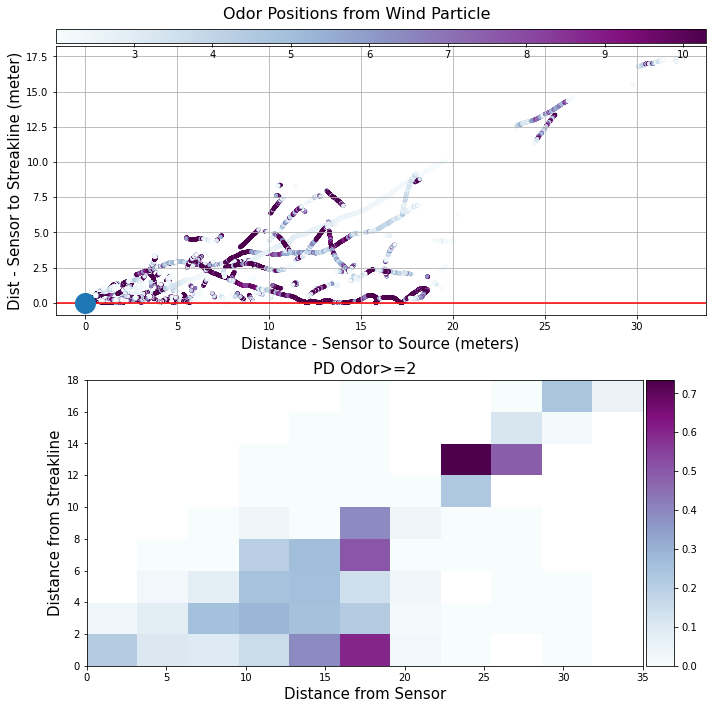

In [53]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(10,10) , gridspec_kw={'height_ratios': [4,4]})

#plot wind vs odor from source and each other
f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
# area = df.radius**2*0.4*m.pi #area
# ax1.scatter(area[0:30]**2,df.mock[0:30])
# ax1.scatter(df.sync_time[::300], df.mock[::300],  facecolors='none', edgecolors='b', s = area[::300])
var = ax1.scatter(df_occurence.odor_from_source, df_occurence.odor_from_wind, cmap = 'BuPu', c = df_occurence.odor,  s = 10)
ax1.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 15)
ax1.set_ylabel('Dist - Sensor to Streakline (meter)' , fontsize = 15)

ax1.grid()

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'horizontal')

x = np.linspace(0,35,12)
y = np.linspace(0,18,10)
# H, x, y = np.histogram2d(df_occurence.odor_from_source, df_occurence.odor_from_wind, bins=(x, y))
# H = H.T 
# ax = plt.axes (xlim=(0,60), ylim=(0,60))
ax2.set_title('PD Odor>=2', fontsize = 16)
ax2.set_xlabel('Distance from Sensor', fontsize = 15)
ax2.set_ylabel('Distance from Streakline', fontsize = 15)
var2 = ax2.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'BuPu', extent=[x[0], x[-1], y[0], y[-1]])


divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()
f.savefig(dir_save+'Coll0'+str(collection_number)+'_prob_encounters.jpeg')

### HeatMap for P(No-Encounters)

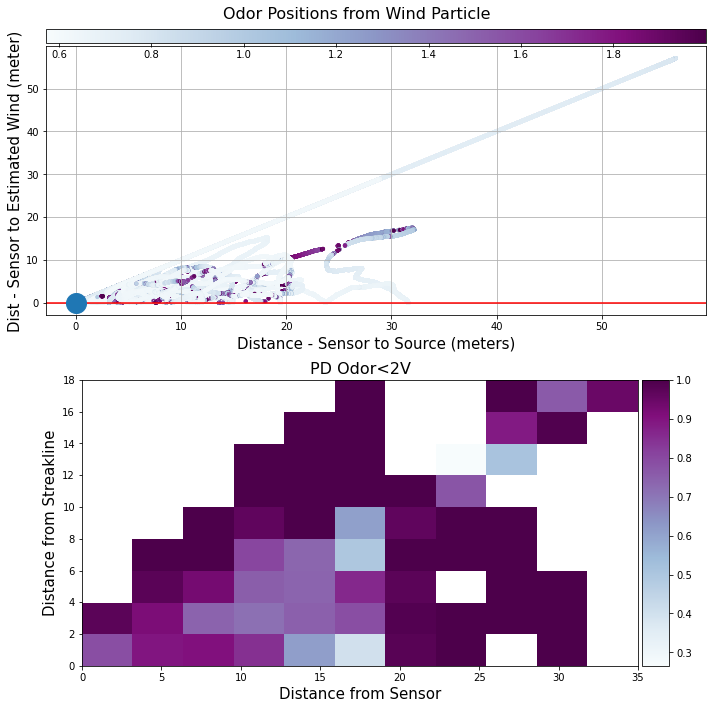

In [54]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(10,10) , gridspec_kw={'height_ratios': [4,4]})

#plot wind vs odor from source and each other
f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
# area = df.radius**2*0.4*m.pi #area
# ax1.scatter(area[0:30]**2,df.mock[0:30])
# ax1.scatter(df.sync_time[::300], df.mock[::300],  facecolors='none', edgecolors='b', s = area[::300])
var = ax1.scatter(df_no_occurence.odor_from_source, df_no_occurence.odor_from_wind, cmap = 'BuPu', c = df_no_occurence.odor,  s = 10)
ax1.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 15)
ax1.set_ylabel('Dist - Sensor to Estimated Wind (meter)' , fontsize = 15)
# ax1.xaxis.set_ticks(np.linspace(0, 30, 31).astype(int))
# ax1.yaxis.set_ticks(np.linspace(0, 35, 10).astype(int))
ax1.grid()

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'horizontal')

x = np.linspace(0,35,12)
y = np.linspace(0,18,10)
# H, x, y = np.histogram2d(df_no_occurence.odor_from_source, df_no_occurence.odor_from_wind, bins=(x, y))
# H = H.T 
# ax = plt.axes (xlim=(0,60), ylim=(0,60))
ax2.set_title('PD Odor<2V', fontsize = 16)
ax2.set_xlabel('Distance from Sensor', fontsize = 15)
ax2.set_ylabel('Distance from Streakline', fontsize = 15)
var2 = ax2.imshow(No_Encounters, interpolation='nearest', origin='lower',cmap = 'BuPu', extent=[x[0], x[-1], y[0], y[-1]])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()
f.savefig(dir_save+'Coll0'+str(collection_number)+'_prob_noencounter.jpeg')

### Time Series

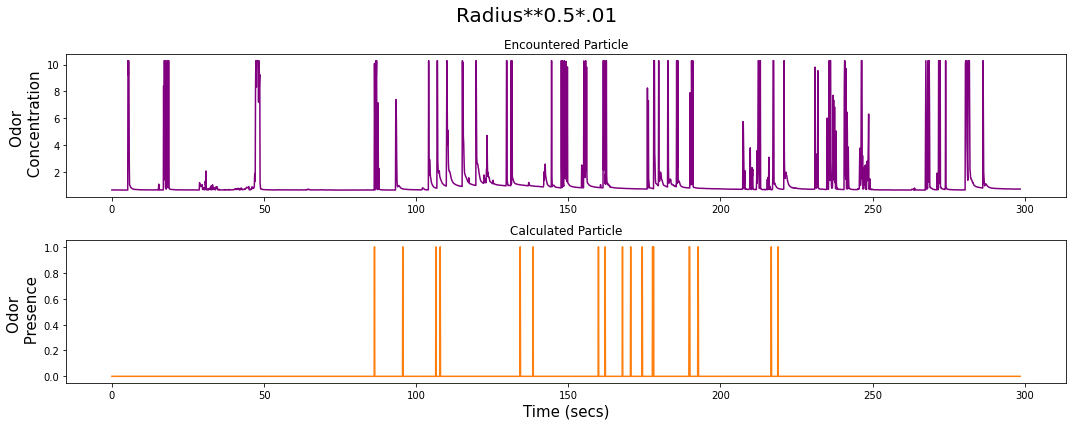

In [9]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(15,6))
# ax1.set_prop_cycle('color',[plt.cm.OrRd(i) for i in df.odor])

# ax1.set_facecolor('black')
ax1.plot(df.sync_time, df.odor, color='Purple')
ax1.set_ylabel('Odor \n Concentration', fontsize=15)
ax1.title.set_text('Encountered Particle')
ax2.plot(df.sync_time,df.odor_expected, color='C1')
ax2.set_xlabel('Time (secs)', fontsize=15)
ax2.set_ylabel('Odor \n Presence', fontsize=15)
ax2.title.set_text('Calculated Particle')

f.suptitle('Radius**0.5*.01', fontsize =20)
f.tight_layout()
f.savefig(dir_save+'Coll0'+str(collection_number)+'_encounteredVsExpected.jpeg')

### Summary Plot

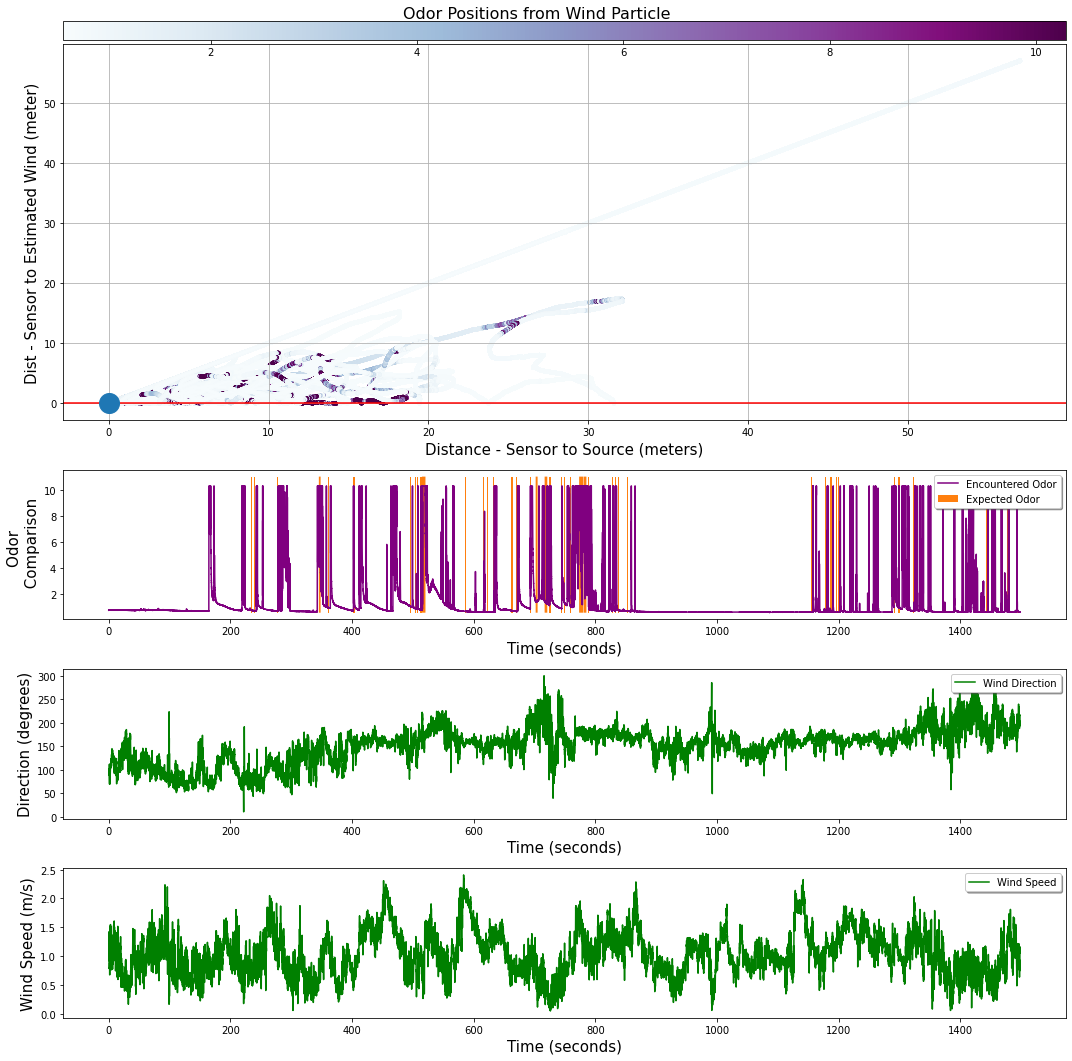

In [82]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize =(15,15) , gridspec_kw={'height_ratios': [8,3,3,3]})

#plot wind vs odor from source and each other
f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
# ax1 = plt.axes(xlim =(0,35), ylim=(-5,28))
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
# area = df.radius**2*0.4*m.pi #area
# ax1.scatter(area[0:30]**2,df.mock[0:30])
# ax1.scatter(df.sync_time[::300], df.mock[::300],  facecolors='none', edgecolors='b', s = area[::300])
var = ax1.scatter(df.odor_from_source, df.odor_from_wind, cmap = 'BuPu', c = df.odor,  s = 10)
ax1.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 15)
ax1.set_ylabel('Dist - Sensor to Estimated Wind (meter)' , fontsize = 15)
# ax1.xaxis.set_ticks(np.linspace(0, 30, 31).astype(int))
# ax1.yaxis.set_ticks(np.linspace(0, 35, 10).astype(int))
ax1.grid()

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'horizontal')

#plot concentration
ax2.plot(df.sync_time,df.odor,color='Purple' , label="Encountered Odor")
ax2.fill_between(df.sync_time, df.odor.min(), 11,where=df.odor_expected>0 ,facecolor='C1', alpha=1, label="Expected Odor")
# ax2.plot(df.sync_time, df.odor_expected, label="Expected Odor")
ax2.set_xlabel('Time (seconds)' , fontsize = 15)
ax2.set_ylabel('Odor \n Comparison' , fontsize = 15)
# ax2.set_facecolor('black')

lgd=ax2.legend(loc='upper right',fancybox=True, shadow=True)

## plot direction
ax3.plot(df.sync_time,df.D, color = 'green', label="Wind Direction")
# ax3.plot(df.sync_time,sensor_direction, color = 'purple', label="Sensor Direction")
ax3.set_xlabel('Time (seconds)' , fontsize = 15)
ax3.set_ylabel('Direction (degrees)' , fontsize = 15)
# ax3.axhline(150, color = 'red')
lgd=ax3.legend(loc='upper right',fancybox=True, shadow=True)



## plot speed
ax4.plot(df.sync_time,df.S2, color = 'green', label="Wind Speed")
ax4.set_xlabel('Time (seconds)' , fontsize = 15)
ax4.set_ylabel('Wind Speed (m/s)' , fontsize = 15)
lgd=ax4.legend(loc='upper right',fancybox=True, shadow=True)
# ax4.axhline(1.0, color = 'red')

f.tight_layout()


# f.savefig(dir_save+'Coll0'+str(collection_number)+'_plot_full.jpeg')

In [40]:
## ABOVE THRESHOLD
query = 'odor >= 1'
df_threshold_up =df.query(query)

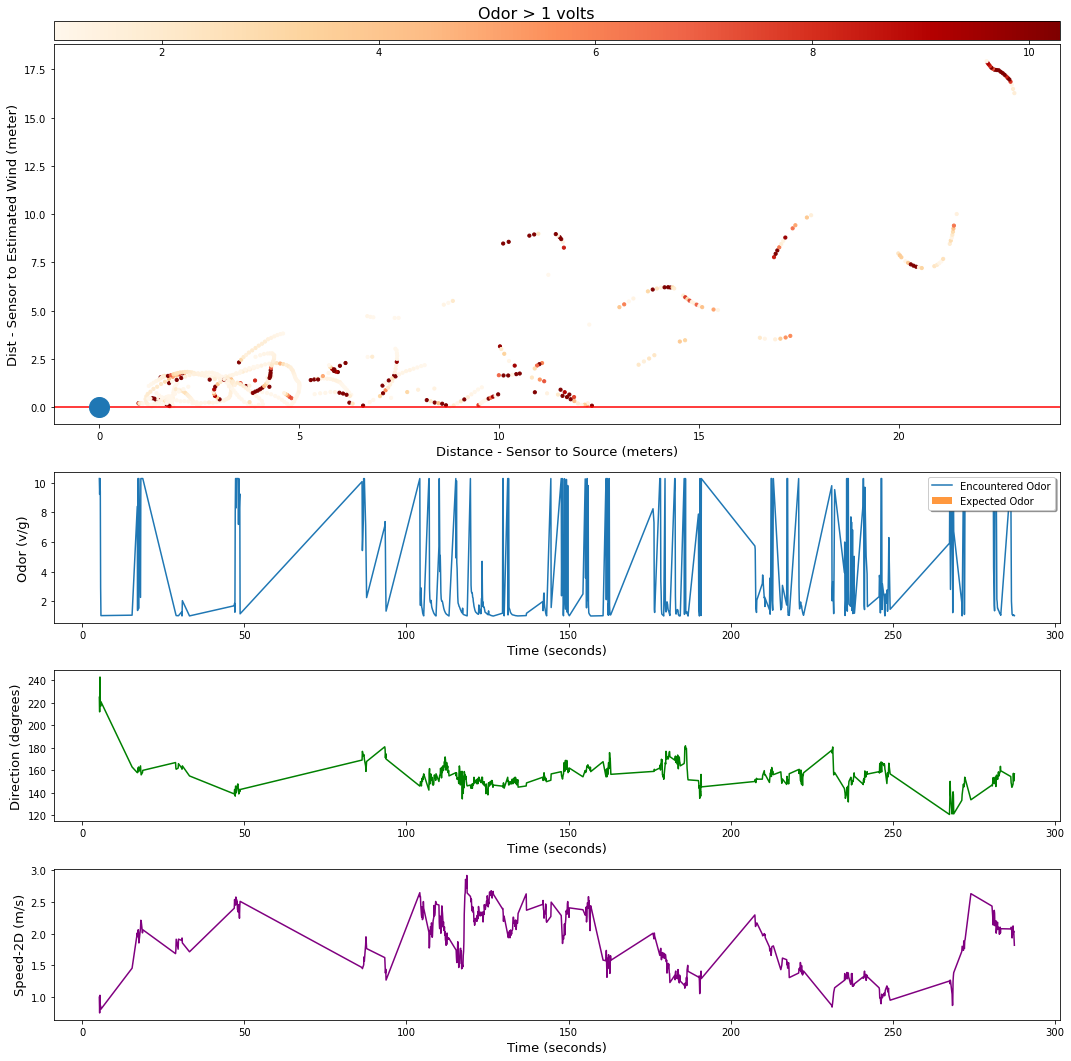

In [41]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize =(15,15) , gridspec_kw={'height_ratios': [8,3,3,3]})

f.suptitle('Odor > 1 volts', fontsize = 16)

ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
# area = df_threshold_up.radius**2*4*m.pi #area
# ax1.scatter(df_threshold_up.odor_from_source, df_threshold_up.mock,  facecolors='none', edgecolors='b', s = area)
var = ax1.scatter(df_threshold_up.odor_from_source, df_threshold_up.odor_from_wind, cmap = 'OrRd', c = df_threshold_up.odor,  s = 10)
ax1.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 13)
ax1.set_ylabel('Dist - Sensor to Estimated Wind (meter)' , fontsize = 13)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'horizontal')

#plot concentration
ax2.plot(df_threshold_up.sync_time,df_threshold_up.odor, label="Encountered Odor")
ax2.fill_between(df_threshold_up.sync_time, df_threshold_up.odor.min(),df_threshold_up.odor.max(),where=df_threshold_up.odor_expected>0 ,facecolor='C1', alpha=0.8, label="Expected Odor")
ax2.set_xlabel('Time (seconds)' , fontsize = 13)
ax2.set_ylabel('Odor (v/g)' , fontsize = 13)
lgd=ax2.legend(loc='upper right',fancybox=True, shadow=True)

## plot direction
ax3.plot(df_threshold_up.sync_time,df_threshold_up.D, color = 'green', label="Wind Direction")
ax3.set_xlabel('Time (seconds)' , fontsize = 13)
ax3.set_ylabel('Direction (degrees)' , fontsize = 13)

## plot speed
ax4.plot(df_threshold_up.sync_time, df_threshold_up.S2, color = 'purple', label="Wind Speed")
ax4.set_xlabel('Time (seconds)' , fontsize = 13)
ax4.set_ylabel('Speed-2D (m/s)' , fontsize = 13)


f.tight_layout()
# f.savefig('test_plot_up.jpeg')

In [286]:
## ABOVE THRESHOLD
query_down = 'odor < 1'
df_threshold_down =df.query(query_down)

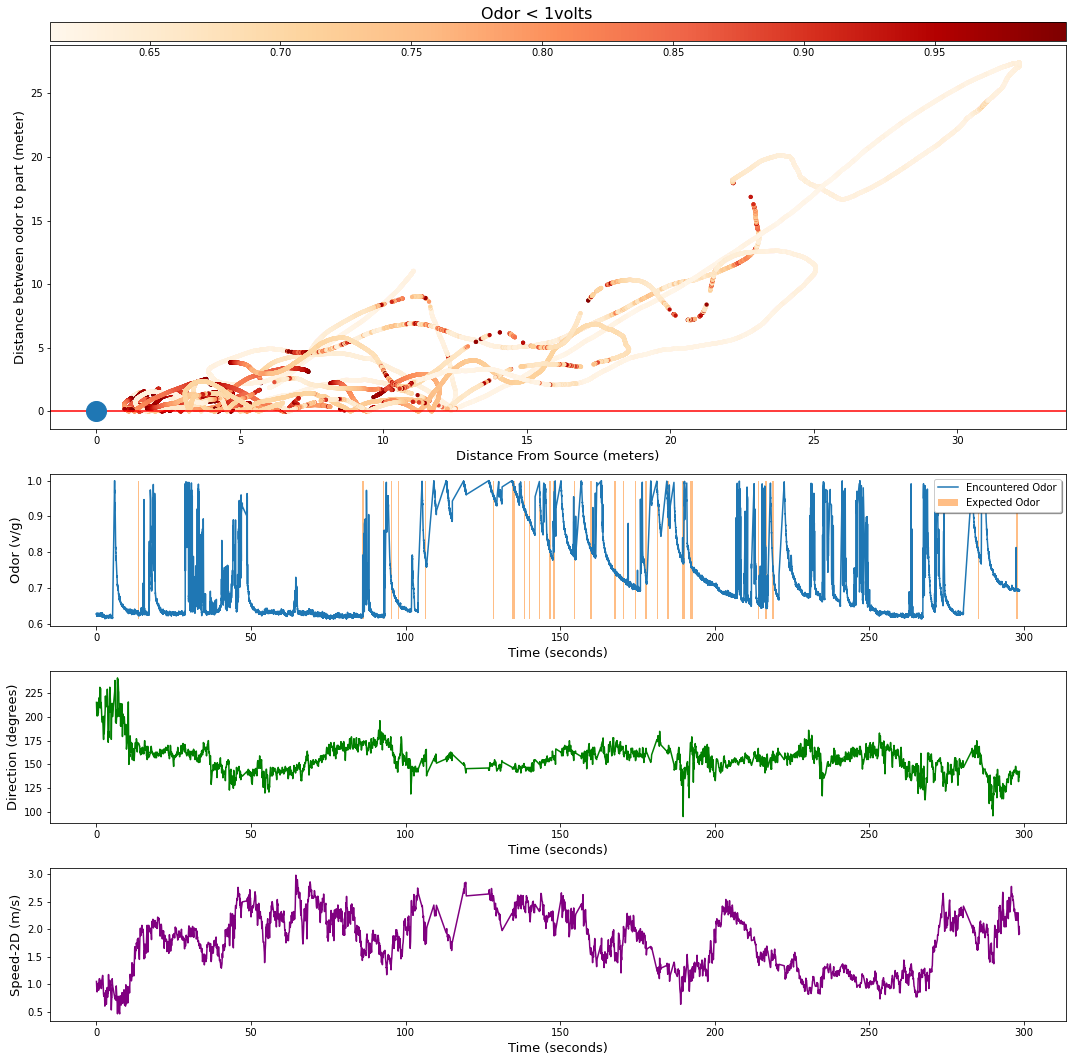

In [289]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize =(15,15) , gridspec_kw={'height_ratios': [8,3,3,3]})

f.suptitle('Odor < 1volts', fontsize = 16)
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df_threshold_down.odor_from_source, df_threshold_down.odor_from_wind, cmap = 'OrRd', c = df_threshold_down.odor,  s = 10)
ax1.set_xlabel('Distance From Source (meters)' , fontsize = 13)
ax1.set_ylabel('Distance between odor to part (meter)' , fontsize = 13)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('top', size='5%', pad=0.05)
f.colorbar(var, cax=cax, orientation = 'horizontal')

#plot concentration
ax2.plot(df_threshold_down.sync_time,df_threshold_down.odor, label="Encountered Odor")
ax2.fill_between(df_threshold_down.sync_time, df_threshold_down.odor.min(),df_threshold_down.odor.max(),where=df_threshold_down.odor_expected>0 ,facecolor='C1', alpha=0.5, label="Expected Odor")
ax2.set_xlabel('Time (seconds)' , fontsize = 13)
ax2.set_ylabel('Odor (v/g)' , fontsize = 13)
lgd=ax2.legend(loc='upper right',fancybox=True, shadow=True)

## plot direction
ax3.plot(df_threshold_down.sync_time,df_threshold_down.D, color = 'green', label="Wind Direction")
ax3.set_xlabel('Time (seconds)' , fontsize = 13)
ax3.set_ylabel('Direction (degrees)' , fontsize = 13)

## plot speed
ax4.plot(df_threshold_down.sync_time, df_threshold_down.S2, color = 'purple', label="Wind Speed")
ax4.set_xlabel('Time (seconds)' , fontsize = 13)
ax4.set_ylabel('Speed-2D (m/s)' , fontsize = 13)
f.tight_layout()

# f.savefig('test_plot_down.jpeg')